In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\91984\Downloads\TCS_historical_data_Daily_5_Years.csv")

In [3]:
df

,Date,Open,High,Low,Close,Volume,Exchange
0,2025-10-03,2924.0,2924.00,2891.10,2903.00,2799767,NSE
1,2025-10-01,2891.0,2924.80,2866.60,2916.80,1941068,NSE
2,2025-09-30,2911.0,2915.30,2885.10,2894.90,2228350,NSE
3,2025-09-29,2916.0,2929.30,2894.00,2904.30,3084635,NSE
4,2025-09-26,2941.0,2954.80,2891.30,2905.40,3876112,NSE
...,...,...,...,...,...,...,...
1227,2020-10-23,2687.8,2702.00,2670.10,2686.80,3499372,NSE
1228,2020-10-22,2661.0,2686.65,2638.10,2671.15,5262311,NSE
1229,2020-10-21,2739.0,2749.00,2663.05,2675.40,4570175,NSE
1230,2020-10-20,2725.0,2759.90,2717.95,2739.00,3406298,NSE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1232 non-null   object 
 1   Open      1232 non-null   float64
 2   High      1232 non-null   float64
 3   Low       1232 non-null   float64
 4   Close     1232 non-null   float64
 5   Volume    1232 non-null   int64  
 6   Exchange  1232 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 67.5+ KB


In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Exchange'], dtype='object')

In [6]:
# df['Date '] = pd.to_datetime(df['Date '])

In [7]:
df.drop(columns=['Exchange'],inplace=True)

In [8]:
df.describe()

,Open,High,Low,Close,Volume
count,1232.000000,1232.000000,1232.000000,1232.000000,1.232000e+03
mean,3512.356006,3543.268709,3480.006818,3510.871510,2.429368e+06
std,407.145359,412.034451,403.722241,407.448146,1.293514e+06
min,2604.000000,2655.000000,2600.050000,2604.600000,6.505700e+04
25%,3218.125000,3243.700000,3192.000000,3215.325000,1.622162e+06
50%,3435.000000,3464.850000,3410.950000,3440.875000,2.084541e+06
75%,3810.000000,3840.312500,3772.250000,3810.950000,2.898771e+06
max,4576.000000,4592.250000,4512.000000,4553.750000,1.350916e+07


In [9]:
df=df.copy(deep=True)
col=['Open', 'High', 'Low', 'Close', 'Volume']

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [11]:
for i in col:
    q25,q75=np.percentile(df[i],25),np.percentile(df[i],75)
    IQR = q75 - q25
    Threshold=IQR*1.5
    lower,upper=q25-Threshold,q75+Threshold
    outliers=[j for j in df[i] if j < lower or j > upper]
    for k in outliers:
        data_1=df.drop(df.index[df[i]==k],axis=0)

In [12]:
df=data_1

In [13]:
from sklearn.preprocessing import MinMaxScaler
features = ['Open', 'High', 'Low', 'Volume']
scalerx = MinMaxScaler()
scalery = MinMaxScaler()

In [14]:
X=scalerx.fit_transform(df[features])

In [15]:
Y=scalery.fit_transform(df[["Close"]])

In [16]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.8,random_state=42)

In [17]:
df.shape

(1231, 5)

In [18]:
xtrain.shape

(984, 4)

In [19]:
xtrain_reshaped = np.reshape(xtrain, (xtrain.shape[0],1, xtrain.shape[1]))

In [20]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
model_lstm = Sequential()

# Add the first LSTM layer.
# return_sequences=True is needed if you want to stack another LSTM layer
model_lstm.add(LSTM(64, activation='relu', input_shape=(1, 4), return_sequences=True))
model_lstm.add(Dropout(0.2))

# Add a second LSTM layer without return_sequences=True
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(Dropout(0.2))

# Output layer for regression
model_lstm.add(Dense(1, activation='linear'))

# Compile
model_lstm.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_squared_error', 'MeanAbsolutePercentageError', 'mae'] # ADDED 'mae'
)

max_mae = 0.005 # Ensure this variable is defined globally or passed to the callback

class StopCond(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the training MAE
        mae = logs.get('mae')
        
        # Check if the metric exists AND if the condition is met
        if mae is not None and mae < max_mae:
            print(f"MAE threshold condition has been satisfied. MAE: {mae:.6f} < Max MAE: {max_mae}")
            self.model.stop_training = True
early_stop = StopCond()
history1 = model_lstm.fit(
    xtrain_reshaped, ytrain,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - MeanAbsolutePercentageError: 90.2433 - loss: 0.2188 - mae: 0.4211 - mean_squared_error: 0.2188 - val_MeanAbsolutePercentageError: 77.4169 - val_loss: 0.1923 - val_mae: 0.3874 - val_mean_squared_error: 0.1923
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - MeanAbsolutePercentageError: 69.2767 - loss: 0.1192 - mae: 0.2946 - mean_squared_error: 0.1192 - val_MeanAbsolutePercentageError: 37.6530 - val_loss: 0.0583 - val_mae: 0.1908 - val_mean_squared_error: 0.0583
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - MeanAbsolutePercentageError: 46.5632 - loss: 0.0215 - mae: 0.1121 - mean_squared_error: 0.0215 - val_MeanAbsolutePercentageError: 28.8510 - val_loss: 0.0075 - val_mae: 0.0721 - val_mean_squared_error: 0.0075
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - MeanAbsolutePercentageError: 43.0398 - loss: 0.0118 - mae: 0.0858 - mean_squared_error: 0.0118 - val_MeanAbsolutePercentageError: 20.1831 - val_loss: 0.0053 -

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


xtest_reshaped = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))
y_pred1 = model_lstm.predict(xtest_reshaped)
y_pred1 = np.array(y_pred1).flatten()
mse = mean_squared_error(ytest, y_pred1)
r2 = r2_score(ytest, y_pred1)

# Change the print statement to reflect the correct metric
print(f" Mse : {mse:.6f}%")
print(f" r2 : {r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step
 Mse : 0.000265%
 r2 : 0.9942


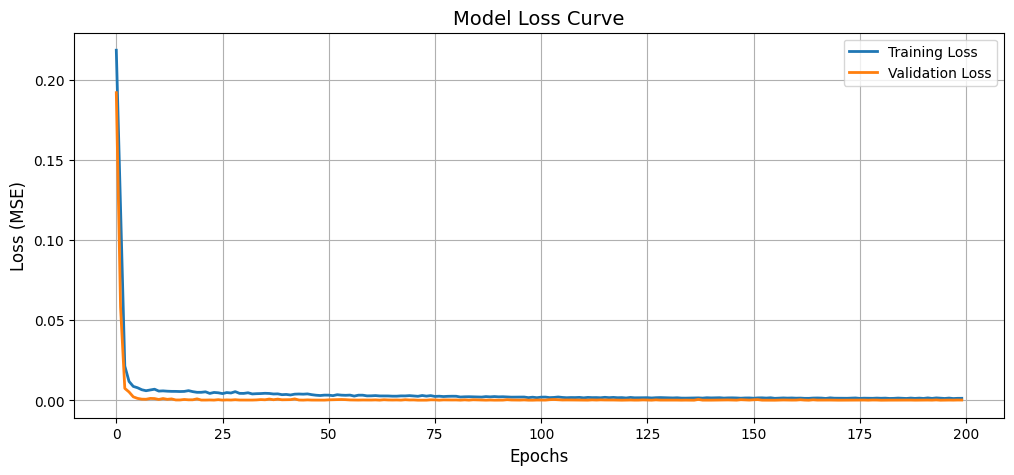

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(history1.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history1.history['val_loss'], label='Validation Loss', linewidth=2)

plt.title('Model Loss Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

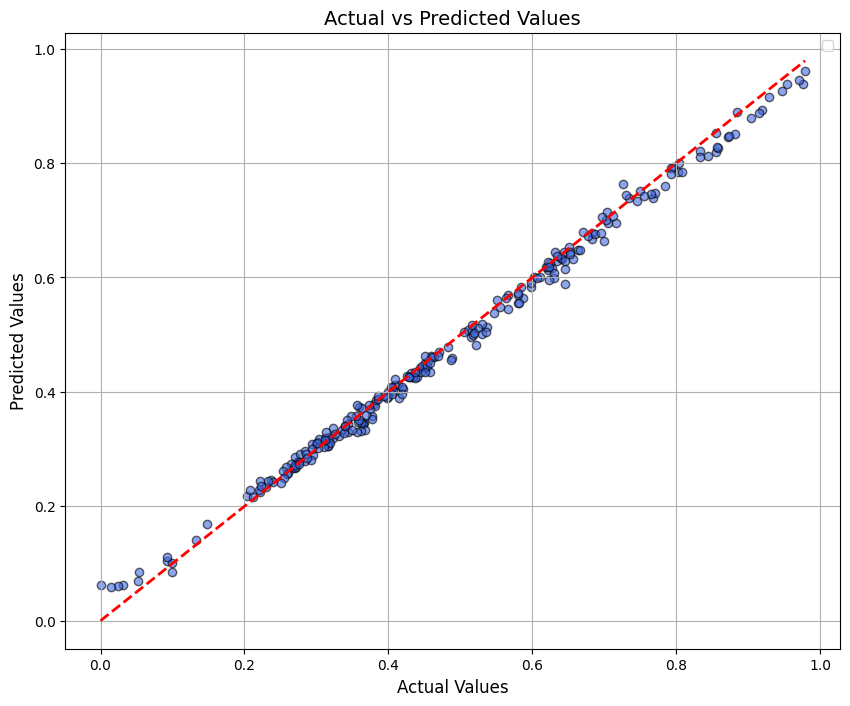

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(ytest,y_pred1,alpha=0.6,color="royalblue",edgecolor='k')

min_val=min(min(ytest),min(y_pred1))
max_val = max(max(ytest),max(y_pred1))

plt.plot([min_val,max_val],[min_val,max_val],color='red',linestyle='--',linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
y_pred_reshaped = y_pred1.reshape(-1, 1)
y_pred_actual = scalery.inverse_transform(y_pred_reshaped)

Hence,LSTM is the best one for the prediction

input values are "OPEN ","HIGH ","LOW ","PREV. CLOSE ","ltp ","52W H ","52W L ","VOLUME ","No of trades "

In [25]:
data = pd.read_csv(r"C:\Users\91984\Downloads\Quote-Equity-TCS-EQ-15-09-2025-to-15-10-2025.csv")

In [26]:
data

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,15-Oct-2025,EQ,"2,971.00","2,979.70","2,951.00","2,960.30","2,970.00","2,969.80","2,967.01","4,494.90","2,866.60","42,82,226","12,70,53,86,117.20","1,46,773"
1,14-Oct-2025,EQ,"3,021.00","3,027.20","2,955.50","3,007.20","2,960.00","2,960.30","2,976.34","4,494.90","2,866.60","36,11,416","10,74,87,94,587.50","1,83,673"
2,13-Oct-2025,EQ,"3,027.00","3,035.50","2,998.20","3,028.30","3,006.00","3,007.20","3,011.37","4,494.90","2,866.60","28,66,865","8,63,31,80,149.10","1,69,572"
3,10-Oct-2025,EQ,"3,050.00","3,070.00","3,006.90","3,061.70","3,028.00","3,028.30","3,032.16","4,494.90","2,866.60","88,17,365","26,73,56,29,672.60","2,44,153"
4,09-Oct-2025,EQ,"3,034.00","3,066.00","3,020.00","3,027.20","3,060.20","3,061.70","3,046.36","4,494.90","2,866.60","32,11,304","9,78,27,98,225.60","1,33,703"
5,08-Oct-2025,EQ,"2,975.00","3,043.00","2,968.00","2,973.70","3,031.50","3,027.20","3,024.78","4,494.90","2,866.60","41,21,889","12,46,78,11,108.50","1,54,336"
6,07-Oct-2025,EQ,"2,995.00","3,004.50","2,955.50","2,988.40","2,975.00","2,973.70","2,971.70","4,494.90","2,866.60","30,62,943","9,10,21,39,525.60","1,41,987"
7,06-Oct-2025,EQ,"2,902.00","2,993.60","2,895.60","2,901.90","2,988.00","2,988.40","2,959.88","4,494.90","2,866.60","21,12,774","6,25,35,56,716.30","1,00,920"
8,03-Oct-2025,EQ,"2,924.00","2,924.00","2,891.10","2,914.20","2,903.00","2,901.90","2,902.27","4,494.90","2,866.60","28,99,519","8,41,51,75,156.20","1,56,466"
9,01-Oct-2025,EQ,"2,891.00","2,924.80","2,866.60","2,888.40","2,915.10","2,914.20","2,897.26","4,494.90","2,866.60","19,52,902","5,65,80,70,903.00","1,24,217"


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           22 non-null     object
 1   series         22 non-null     object
 2   OPEN           22 non-null     object
 3   HIGH           22 non-null     object
 4   LOW            22 non-null     object
 5   PREV. CLOSE    22 non-null     object
 6   ltp            22 non-null     object
 7   close          22 non-null     object
 8   vwap           22 non-null     object
 9   52W H          22 non-null     object
 10  52W L          22 non-null     object
 11  VOLUME         22 non-null     object
 12  VALUE          22 non-null     object
 13  No of trades   22 non-null     object
dtypes: object(14)
memory usage: 2.5+ KB


In [28]:
numeric_columns = ["OPEN ","HIGH ","LOW ","PREV. CLOSE ","close ","ltp ","52W H ","52W L ","VOLUME ","No of trades "]

In [29]:
for i in numeric_columns:
    data[i]=data[i].str.replace(',','')
    data[i]=pd.to_numeric(data[i],errors='coerce')

In [30]:
data.drop(columns=['VALUE ','vwap ',"series ","PREV. CLOSE ","ltp ","52W H ","52W L ","No of trades "],inplace=True)

In [31]:
data['Date '] = pd.to_datetime(data['Date '])
data.set_index('Date ', inplace=True)

In [32]:
data

,OPEN,HIGH,LOW,close,VOLUME
Date,,,,,
2025-10-15,2971.0,2979.7,2951.0,2969.8,4282226
2025-10-14,3021.0,3027.2,2955.5,2960.3,3611416
2025-10-13,3027.0,3035.5,2998.2,3007.2,2866865
2025-10-10,3050.0,3070.0,3006.9,3028.3,8817365
2025-10-09,3034.0,3066.0,3020.0,3061.7,3211304
2025-10-08,2975.0,3043.0,2968.0,3027.2,4121889
2025-10-07,2995.0,3004.5,2955.5,2973.7,3062943
2025-10-06,2902.0,2993.6,2895.6,2988.4,2112774
2025-10-03,2924.0,2924.0,2891.1,2901.9,2899519


In [33]:
data = data.rename(columns={"Date ":"Date","OPEN ":"Open","HIGH ":'High',"LOW ":'Low','close ':"Close","VOLUME ":'Volume'})

In [34]:
data["Close"]

Date 
2025-10-15    2969.8
2025-10-14    2960.3
2025-10-13    3007.2
2025-10-10    3028.3
2025-10-09    3061.7
2025-10-08    3027.2
2025-10-07    2973.7
2025-10-06    2988.4
2025-10-03    2901.9
2025-10-01    2914.2
2025-09-30    2888.4
2025-09-29    2896.1
2025-09-26    2899.1
2025-09-25    2957.4
2025-09-24    3035.4
2025-09-23    3062.4
2025-09-22    3073.8
2025-09-19    3169.2
2025-09-18    3176.7
2025-09-17    3172.8
2025-09-16    3145.7
2025-09-15    3111.9
Name: Close, dtype: float64

In [35]:
X1=data.drop(columns ="Close")
value = scalerx.transform(X1)
value = np.reshape(value, (value.shape[0], 1, value.shape[1]))
predict1 = model_lstm.predict(value)
predict1 = np.array(predict1).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [36]:
y1 = predict1.reshape(-1, 1)
y1 = scalery.inverse_transform(y1)

In [37]:
y1

array([[2978.0735],
       [3006.3706],
       [3026.2183],
       [3046.464 ],
       [3045.7812],
       [3009.9065],
       [2996.0198],
       [2949.8303],
       [2917.3728],
       [2906.711 ],
       [2912.754 ],
       [2917.8345],
       [2931.16  ],
       [3003.5146],
       [3054.9634],
       [3068.8928],
       [3087.5046],
       [3170.3   ],
       [3188.092 ],
       [3163.2   ],
       [3129.1526],
       [3117.5142]], dtype=float32)

In [38]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-15,2971.0,2979.7,2951.0,2969.8,4282226
2025-10-14,3021.0,3027.2,2955.5,2960.3,3611416
2025-10-13,3027.0,3035.5,2998.2,3007.2,2866865
2025-10-10,3050.0,3070.0,3006.9,3028.3,8817365
2025-10-09,3034.0,3066.0,3020.0,3061.7,3211304
2025-10-08,2975.0,3043.0,2968.0,3027.2,4121889
2025-10-07,2995.0,3004.5,2955.5,2973.7,3062943
2025-10-06,2902.0,2993.6,2895.6,2988.4,2112774
2025-10-03,2924.0,2924.0,2891.1,2901.9,2899519


In [39]:
y2=data["Close"].values.reshape(-1, 1)

In [40]:
y2

array([[2969.8],
       [2960.3],
       [3007.2],
       [3028.3],
       [3061.7],
       [3027.2],
       [2973.7],
       [2988.4],
       [2901.9],
       [2914.2],
       [2888.4],
       [2896.1],
       [2899.1],
       [2957.4],
       [3035.4],
       [3062.4],
       [3073.8],
       [3169.2],
       [3176.7],
       [3172.8],
       [3145.7],
       [3111.9]])

In [41]:
mse = mean_squared_error(y1, y2)
r2 = r2_score(y1, y2)

print(f" Mse : {mse:.6f}%")
print(f" r2 : {r2:.4f}")

 Mse : 503.519195%
 r2 : 0.9315


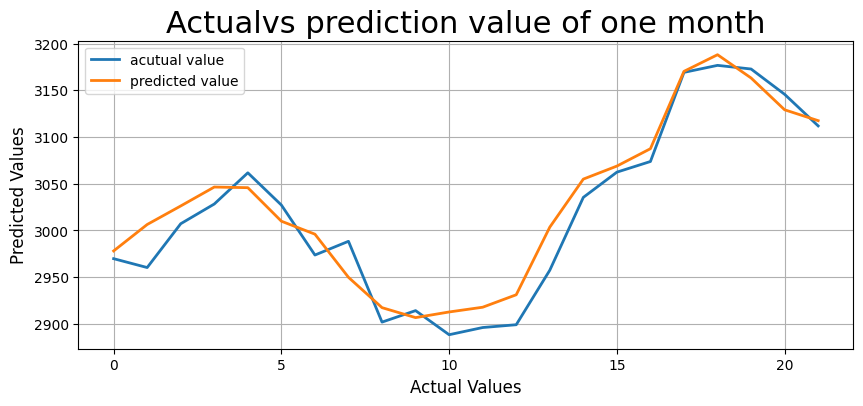

In [42]:
plt.figure(figsize=(10,4))
plt.plot(y2,label="acutual value",linewidth=2)
plt.plot(y1,label="predicted value",linewidth=2)
plt.title("Actualvs prediction value of one month",fontsize=22)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()